# Task 1: A classification example: fetal heart diagnosis condition diagnosis

In [1]:
# importing general stuff
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from graphviz import Digraph
from abc import ABC, abstractmethod

# linear
from sklearn.linear_model import Perceptron, LogisticRegression, LinearRegression, Ridge, Lasso

# ensemble
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor, GradientBoostingRegressor

# neural networks
from sklearn.neural_network import MLPClassifier, MLPRegressor

# other methods
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.svm import LinearSVC

# metrics, model selection etc.
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.metrics import mean_squared_error, accuracy_score, accuracy_score
from sklearn.base import BaseEstimator, ClassifierMixin, RegressorMixin

## Step 1: Reading the data 

In [2]:
# Read the CSV file.
data = pd.read_csv('http://www.cse.chalmers.se/~richajo/dit866/data/CTG.csv', skiprows=1)

# Select the relevant numerical columns.
selected_cols = ['LB', 'AC', 'FM', 'UC', 'DL', 'DS', 'DP', 'ASTV', 'MSTV', 'ALTV',
                 'MLTV', 'Width', 'Min', 'Max', 'Nmax', 'Nzeros', 'Mode', 'Mean',
                 'Median', 'Variance', 'Tendency', 'NSP']
data = data[selected_cols].dropna()

# Shuffle the dataset.
data_shuffled = data.sample(frac=1.0, random_state=0)

# Split into input part X and output part Y.
X = data_shuffled.drop('NSP', axis=1)

# Map the diagnosis code to a human-readable label.
def to_label(y):
    return [None, 'normal', 'suspect', 'pathologic'][(int(y))]

Y = data_shuffled['NSP'].apply(to_label)

# Partition the data into training and test sets.
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2, random_state=0)

## Step 2: Training the baseline classifier 

In [3]:
# most frequent classifier
clf_dummy = DummyClassifier(strategy='most_frequent')

dummy_acc = cross_val_score(clf_dummy, Xtrain, Ytrain, cv=5).mean()
print(f'The accuracy of the dummy classifier is: {dummy_acc}')

The accuracy of the dummy classifier is: 0.7805938344334005


## Step 3: Trying out some different classifiers 

In [4]:
# decision tree classifier
clf_decisionTree = DecisionTreeClassifier()

decisionTree_acc = cross_val_score(clf_decisionTree, Xtrain, Ytrain, cv=5).mean()
print(f'The accuracy of the decision tree classifier is: {decisionTree_acc}')


# random forest
clf_randomForest = RandomForestClassifier(n_estimators=100)

randomForest_acc = cross_val_score(clf_randomForest, Xtrain, Ytrain, cv=5).mean()
print(f'The accuracy of the random forest classifier is: {randomForest_acc}')


# gradient boosting


clf_gradientBoosting = GradientBoostingClassifier()

gradientBoosting_acc = cross_val_score(clf_gradientBoosting, Xtrain, Ytrain, cv=5).mean()
print(f'The accuracy of the gradient boosting classifier is: {gradientBoosting_acc}')

The accuracy of the decision tree classifier is: 0.9200161234928427
The accuracy of the random forest classifier is: 0.9417517877514572
The accuracy of the gradient boosting classifier is: 0.9488245132940657


In [5]:
# perceptron
clf_perceptron = Perceptron()

perceptron_acc = cross_val_score(clf_perceptron, Xtrain, Ytrain, cv=5).mean()
print(f'The accuracy of the perceptron classifier is: {perceptron_acc}')

The accuracy of the perceptron classifier is: 0.83351164180228


In [6]:
# do not work yet
'''
# linear SVC
clf_linearSVC = LinearSVC()

linearSVC_acc = cross_val_score(clf_linearSVC, Xtrain, Ytrain, cv=5).mean()
print('linear SVC:', linearSVC_acc)


# logistic regression
clf_logReg = LogisticRegression(solver='lbfgs', multi_class='auto')

logReg_acc = cross_val_score(clf_logReg, Xtrain, Ytrain, cv=5).mean()
print('logistic regression:', logReg_acc)
''';

In [7]:
# MLPClassifier() not found
'''
# MLP classifier
clf_MLP = MLPCLassifier()

MLP_acc = cross_val_score(clf_MLP, Xtrain, Ytrain, cv=5).mean()
print('MLP:', MLP_acc)
''';

## Step 4: Final evaluation

Gradient boosting seems to best among those that works above.

In [8]:
clf = GradientBoostingClassifier()

clf.fit(Xtrain, Ytrain)
Yguess = clf.predict(Xtest)
print(accuracy_score(Ytest,Yguess))

0.9295774647887324


It performs well also on the test set.

# Task 2: Decision trees for classification 

In [9]:
class DecisionTreeLeaf:

    def __init__(self, value):
        self.value = value

    # This method computes the prediction for this leaf node. This will just return a constant value.
    def predict(self, x):
        return self.value

    # Utility function to draw a tree visually using graphviz.
    def draw_tree(self, graph, node_counter, names):
        node_id = str(node_counter)
        graph.node(node_id, str(self.value), style='filled')
        return node_counter+1, node_id
        
    def __eq__(self, other):
        if isinstance(other, DecisionTreeLeaf):
            return self.value == other.value
        else:
            return False
        
        
class DecisionTreeBranch:

    def __init__(self, feature, threshold, low_subtree, high_subtree):
        self.feature = feature
        self.threshold = threshold
        self.low_subtree = low_subtree
        self.high_subtree = high_subtree

    # For a branch node, we compute the prediction by first considering the feature, and then 
    # calling the upper or lower subtree, depending on whether the feature is or isn't greater
    # than the threshold.
    def predict(self, x):
        if x[self.feature] <= self.threshold:
            return self.low_subtree.predict(x)
        else:
            return self.high_subtree.predict(x)

    # Utility function to draw a tree visually using graphviz.
    def draw_tree(self, graph, node_counter, names):
        node_counter, low_id = self.low_subtree.draw_tree(graph, node_counter, names)
        node_counter, high_id = self.high_subtree.draw_tree(graph, node_counter, names)
        node_id = str(node_counter)
        fname = f'F{self.feature}' if names is None else names[self.feature]
        lbl = f'{fname} > {self.threshold:.4g}?'
        graph.node(node_id, lbl, shape='box', fillcolor='yellow', style='filled, rounded')
        graph.edge(node_id, low_id, 'False')
        graph.edge(node_id, high_id, 'True')
        return node_counter+1, node_id

    
class DecisionTree(ABC, BaseEstimator):

    def __init__(self, max_depth):
        super().__init__()
        self.max_depth = max_depth

    # As usual in scikit-learn, the training method is called *fit*. We first process the dataset so that
    # we're sure that it's represented as a NumPy matrix. Then we call the recursive tree-building method
    # called make_tree (see below).
    def fit(self, X, Y):
        if isinstance(X, pd.DataFrame):
            self.names = X.columns
            X = X.to_numpy()
        elif isinstance(X, list):
            self.names = None
            X = np.array(X)
        else:
            self.names = None
        
        self.root = self.make_tree(X, Y, self.max_depth)
        
    def draw_tree(self):
        graph = Digraph()
        self.root.draw_tree(graph, 0, self.names)
        return graph
    
    # By scikit-learn convention, the method *predict* computes the classification or regression output
    # for a set of instances.
    # To implement it, we call a separate method that carries out the prediction for one instance.
    def predict(self, X):
        if isinstance(X, pd.DataFrame):
            X = X.to_numpy()
        return [self.predict_one(x) for x in X]

    # Predicting the output for one instance.
    def predict_one(self, x):
        return self.root.predict(x)        

    # This is the recursive training 
    def make_tree(self, X, Y, max_depth):

        # We start by computing the default value that will be used if we'll return a leaf node.
        # For classifiers, this will be 
        default_value = self.get_default_value(Y)

        # First the two base cases in the recursion: is the training set completely
        # homogeneous, or have we reached the maximum depth? Then we need to return a leaf.

        # If we have reached the maximum depth, return a leaf with the majority value.
        if max_depth == 0:
            return DecisionTreeLeaf(default_value)

        # If all the instances in the remaining training set have the same output value,
        # return a leaf with this value.
        if self.is_homogeneous(Y):
            return DecisionTreeLeaf(default_value)

        # Select the "most useful" feature and split threshold. To rank the "usefulness" of features,
        # we use one of the classification or regression criteria.
        # For each feature, we call best_split (defined in a subclass). We then maximize over the features.
        n_features = X.shape[1]
        _, best_feature, best_threshold = max(self.best_split(X, Y, feature) for feature in range(n_features))
        
        if best_feature is None:
            return DecisionTreeLeaf(default_value)

        # Split the training set into subgroups, based on whether the selected feature is greater than
        # the threshold or not
        X_low, X_high, Y_low, Y_high = self.split_by_feature(X, Y, best_feature, best_threshold)

        # Build the subtrees using a recursive call. Each subtree is associated
        # with a value of the feature.
        low_subtree = self.make_tree(X_low, Y_low, max_depth-1)
        high_subtree = self.make_tree(X_high, Y_high, max_depth-1)

        if low_subtree == high_subtree:
            return low_subtree

        # Return a decision tree branch containing the result.
        return DecisionTreeBranch(best_feature, best_threshold, low_subtree, high_subtree)
    
    # Utility method that splits the data into the "upper" and "lower" part, based on a feature
    # and a threshold.
    def split_by_feature(self, X, Y, feature, threshold):
        low = X[:,feature] <= threshold
        high = ~low
        return X[low], X[high], Y[low], Y[high]
    
    # The following three methods need to be implemented by the classification and regression subclasses.
    
    @abstractmethod
    def get_default_value(self, Y):
        pass

    @abstractmethod
    def is_homogeneous(self, Y):
        pass

    @abstractmethod
    def best_split(self, X, Y, feature):
        pass

    
class TreeClassifier(DecisionTree, ClassifierMixin):

    def __init__(self, max_depth=10, criterion='maj_sum'):
        super().__init__(max_depth)
        self.criterion = criterion
        
    def fit(self, X, Y):
        # For decision tree classifiers, there are some different ways to measure
        # the homogeneity of subsets.
        if self.criterion == 'maj_sum':
            self.criterion_function = majority_sum_scorer
        elif self.criterion == 'info_gain':
            self.criterion_function = info_gain_scorer
        elif self.criterion == 'gini':
            self.criterion_function = gini_scorer
        else:
            raise Exception(f'Unknown criterion: {self.criterion}')
        super().fit(X, Y)
        self.classes_ = sorted(set(Y))

    # Select a default value that is going to be used if we decide to make a leaf.
    # We will select the most common value.
    def get_default_value(self, Y):
        self.class_distribution = Counter(Y)
        return self.class_distribution.most_common(1)[0][0]
    
    # Checks whether a set of output values is homogeneous. In the classification case, 
    # this means that all output values are identical.
    # We assume that we called get_default_value just before, so that we can access
    # the class_distribution attribute. If the class distribution contains just one item,
    # this means that the set is homogeneous.
    def is_homogeneous(self, Y):
        return len(self.class_distribution) == 1
        
    # Finds the best splitting point for a given feature. We'll keep frequency tables (Counters)
    # for the upper and lower parts, and then compute the impurity criterion using these tables.
    # In the end, we return a triple consisting of
    # - the best score we found, according to the criterion we're using
    # - the id of the feature
    # - the threshold for the best split
    def best_split(self, X, Y, feature):

        # Create a list of input-output pairs, where we have sorted
        # in ascending order by the input feature we're considering.
        XY = sorted(zip(X[:, feature], Y))

        n = len(XY)

        # The frequency tables corresponding to the parts *before and including*
        # and *after* the current element.
        low_distr = Counter()
        high_distr = Counter(Y)

        # Keep track of the best result we've seen so far.
        max_score = -np.inf
        max_i = None

        # Go through all the positions (excluding the last position).
        for i in range(0, n-1):

            # Input and output at the current position.
            x_i = XY[i][0]
            y_i = XY[i][1]

            # Update the frequency tables.
            low_distr[y_i] += 1
            high_distr[y_i] -= 1

            # If the input is equal to the input at the next position, we will
            # not consider a split here.
            x_next = XY[i+1][0]
            if x_i == x_next:
                continue

            # Compute the homogeneity criterion for a split at this position.
            score = self.criterion_function(i+1, low_distr, n-i-1, high_distr)

            # If this is the best split, remember it.
            if score > max_score:
                max_score = score
                max_i = i

        # If we didn't find any split (meaning that all inputs are identical), return
        # a dummy value.
        if max_i is None:
            return -np.inf, None, None

        # Otherwise, return the best split we found and its score.
        split_point = 0.5*(XY[max_i][0] + XY[max_i+1][0])
        return max_score, feature, split_point
    
    
def majority_sum_scorer(n_low, low_distr, n_high, high_distr):
    maj_sum_low = low_distr.most_common(1)[0][1]
    maj_sum_high = high_distr.most_common(1)[0][1]
    return maj_sum_low + maj_sum_high
    
def entropy(distr):
    n = sum(distr.values())
    ps = [n_i/n for n_i in distr.values()]
    return -sum(p*np.log2(p) if p > 0 else 0 for p in ps)

def info_gain_scorer(n_low, low_distr, n_high, high_distr):
    return -(n_low*entropy(low_distr)+n_high*entropy(high_distr))/(n_low+n_high)

def gini_impurity(distr):
    n = sum(distr.values())
    ps = [n_i/n for n_i in distr.values()]
    return 1-sum(p**2 for p in ps)
    
def gini_scorer(n_low, low_distr, n_high, high_distr):
    return -(n_low*gini_impurity(low_distr)+n_high*gini_impurity(high_distr))/(n_low+n_high)

[[ 1.          0.83172611]
 [ 2.          0.89113868]
 [ 3.          0.90231875]
 [ 4.          0.91055935]
 [ 5.          0.91232235]
 [ 6.          0.90997456]
 [ 7.          0.91056453]
 [ 8.          0.9099711 ]
 [ 9.          0.90997281]
 [10.          0.91057142]
 [11.          0.91115622]
 [12.          0.90764576]
 [13.          0.91412162]
 [14.          0.9094278 ]
 [15.          0.91001431]
 [16.          0.91295206]
 [17.          0.91060602]
 [18.          0.91178422]
 [19.          0.91001259]
 [20.          0.90590007]
 [21.          0.90472876]
 [22.          0.90590178]
 [23.          0.90531181]
 [24.          0.90472702]]
The accuracy on the training data is highest with max_depth set to: 13


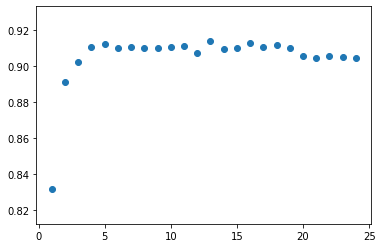

In [10]:
# testing accuracy on training data (tuning the max_depth parameter)
arr = np.empty((24,2))
for i in range(1,25):
    cls = TreeClassifier(max_depth=i)
    cls_acc = cross_val_score(cls, Xtrain, Ytrain, cv=5, error_score='raise').mean()
    arr[i-1,0] = i
    arr[i-1,1] = cls_acc
    #print(f'TreeClassifer accuracy on the training data with max depth {i} is: {cls_acc}')
print(arr)
plt.scatter(arr[:,0], arr[:,1])
#print(np.argmax(np.max(arr, axis=0)))
#print(arr[:,1].max())
d = int(np.where(arr==arr[:,1].max())[0])+1
print(f'The accuracy on the training data is highest with max_depth set to: {d}')

In [11]:
cls = TreeClassifier(max_depth=d)
cls.fit(Xtrain, Ytrain)
Yguess = cls.predict(Xtest)
print('TreeClassifier accuracy when evaluated on the test data:', accuracy_score(Ytest,Yguess))

TreeClassifier accuracy when evaluated on the test data: 0.8732394366197183


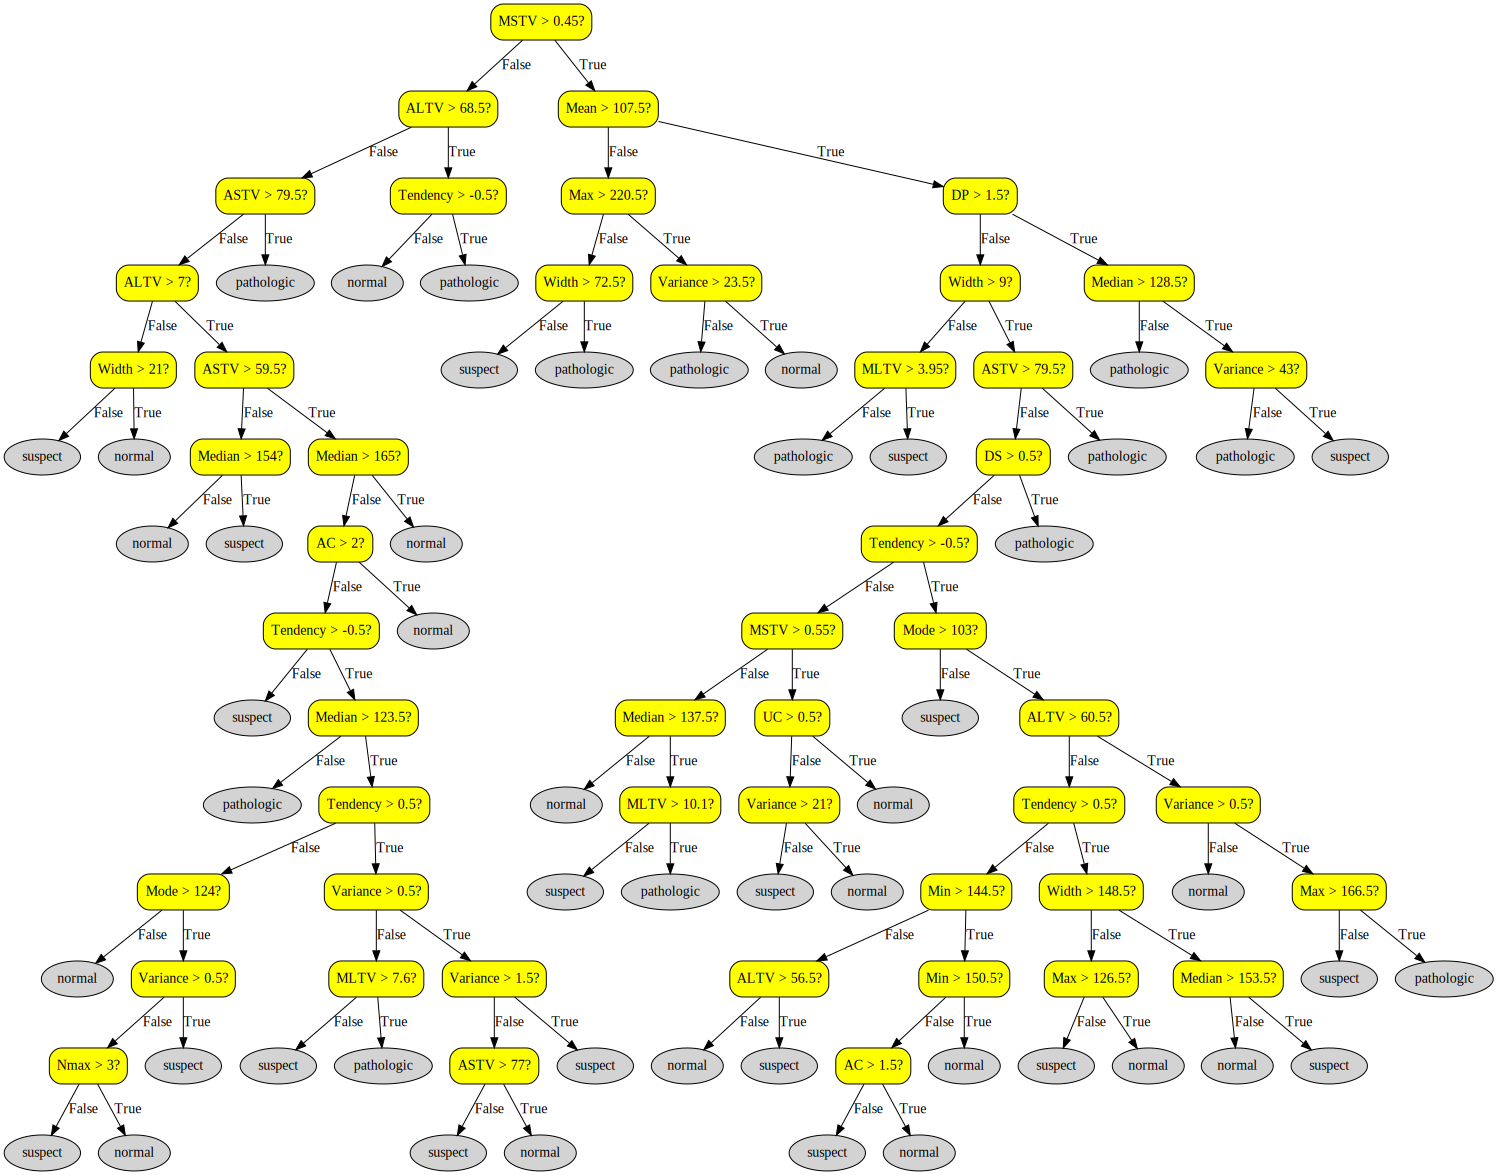

In [12]:
#type(DecisionTree.draw_tree(cls))
DecisionTree.draw_tree(cls)


# Task 3: A regression example: predicting apartment prices

In [13]:
# Read the CSV file using Pandas.
alldata = pd.read_csv('sberbank.csv')

# Convert the timestamp string to an integer representing the year.
def get_year(timestamp):
    return int(timestamp[:4])
alldata['year'] = alldata.timestamp.apply(get_year)

# Select the 9 input columns and the output column.
selected_columns = ['price_doc', 'year', 'full_sq', 'life_sq', 'floor', 'num_room', 'kitch_sq', 'full_all']
alldata = alldata[selected_columns]
alldata = alldata.dropna()

# Shuffle.
alldata_shuffled = alldata.sample(frac=1.0, random_state=0)

# Separate the input and output columns.
X = alldata_shuffled.drop('price_doc', axis=1)
# For the output, we'll use the log of the sales price.
Y = alldata_shuffled['price_doc'].apply(np.log)

# Split into training and test sets.
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2, random_state=0)

In [14]:
# dummy regressor
m1 = DummyRegressor()
score1 = cross_validate(m1, Xtrain, Ytrain, cv=5, scoring='neg_mean_squared_error')['test_score'].mean()
print('The negative MSE of the dummy regressor:', score1)

The negative MSE of the dummy regressor: -0.38925247260237567


In [15]:
# linear regressor
m2 = LinearRegression()
score2 = cross_validate(m2, Xtrain, Ytrain, cv=5, scoring='neg_mean_squared_error')['test_score'].mean()
print('The neagative MSE of the linear regressor:', score2)

The neagative MSE of the linear regressor: -0.3013986588767233


In [42]:
# decision tree regressor
m3 = DecisionTreeRegressor()
score3 = cross_validate(m3, Xtrain, Ytrain, cv=5, scoring='neg_mean_squared_error')['test_score'].mean()
print('The negative MSE of the decision tree regressor:', score3)

The negative MSE of the decision tree regressor: -0.5251104633148539


In [17]:
# random forest regressor
m4 = RandomForestRegressor(n_estimators = 100)
score4 = cross_validate(m4, Xtrain, Ytrain, cv=5, scoring='neg_mean_squared_error')['test_score'].mean()
print('The negative MSE of the random forest regressor:', score4)

The negative MSE of the random forest regressor: -0.28386102898692284


In [18]:
# MLP regressor
m5 = MLPRegressor()
score5 = cross_validate(m5, Xtrain, Ytrain, cv=5, scoring='neg_mean_squared_error', error_score='raise')['test_score'].mean()
print('The negative MSE of the MLP regressor:', score5)

The negative MSE of the MLP regressor: -448.4111095672765


Note on above: This result does not seem correct with such a high MSE.

In [19]:
# Ridge regressor
m6 = Ridge()
score6 = cross_validate(m6, Xtrain, Ytrain, cv=5, scoring='neg_mean_squared_error')['test_score'].mean()
print('The negative MSE of the Ridge regressor:', score6)

The negative MSE of the Ridge regressor: -0.30139784232179767


In [20]:
# Ridge regressor
m7 = Lasso()
score7 = cross_validate(m7, Xtrain, Ytrain, cv=5, scoring='neg_mean_squared_error')['test_score'].mean()
print('The negative MSE of the Lasso regressor:', score7)

The negative MSE of the Lasso regressor: -0.3010470671748872


In [21]:
# gradient boosting regressor
m8 = GradientBoostingRegressor()
score8 = cross_validate(m8, Xtrain, Ytrain, cv=5, scoring='neg_mean_squared_error')['test_score'].mean()
print('The negative MSE of the gradient boosting regressor:', score8)

The negative MSE of the gradient boosting regressor: -0.2645194578211184


Using model 8 (gradient boosting regression) since it has the lowest score on the training data set.

In [22]:
m8.fit(Xtrain, Ytrain)
mean_squared_error(Ytest, m8.predict(Xtest))

0.2714100123717177

The resulting score is still better than any of the other regression models scored on the training data which means that I still think that this model is the best choice.

# (WIP) Task 4: Decision trees for regression

In [23]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [24]:
# Imports provided
from graphviz import Digraph
from sklearn.base import BaseEstimator, RegressorMixin
from abc import ABC, abstractmethod
from collections import Counter
from scipy.stats import levene, fligner

# Additional imports used
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Regressors for comparison
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neural_network import MLPRegressor

In [25]:
class DecisionTreeLeaf:

    def __init__(self, value):
        self.value = value

    # This method computes the prediction for this leaf node. This will just return a constant value.
    def predict(self, x):
        return self.value

    # Utility function to draw a tree visually using graphviz.
    def draw_tree(self, graph, node_counter, names):
        node_id = str(node_counter)
        graph.node(node_id, str(self.value), style='filled')
        return node_counter+1, node_id
        
    def __eq__(self, other):
        if isinstance(other, DecisionTreeLeaf):
            return self.value == other.value
        else:
            return False

class DecisionTreeBranch:

    def __init__(self, feature, threshold, low_subtree, high_subtree):
        self.feature = feature
        self.threshold = threshold
        self.low_subtree = low_subtree
        self.high_subtree = high_subtree

    # For a branch node, we compute the prediction by first considering the feature, and then 
    # calling the upper or lower subtree, depending on whether the feature is or isn't greater
    # than the threshold.
    def predict(self, x):
        if x[self.feature] <= self.threshold:
            return self.low_subtree.predict(x)
        else:
            return self.high_subtree.predict(x)

    # Utility function to draw a tree visually using graphviz.
    def draw_tree(self, graph, node_counter, names):
        node_counter, low_id = self.low_subtree.draw_tree(graph, node_counter, names)
        node_counter, high_id = self.high_subtree.draw_tree(graph, node_counter, names)
        node_id = str(node_counter)
        fname = f'F{self.feature}' if names is None else names[self.feature]
        lbl = f'{fname} > {self.threshold:.4g}?'
        graph.node(node_id, lbl, shape='box', fillcolor='yellow', style='filled, rounded')
        graph.edge(node_id, low_id, 'False')
        graph.edge(node_id, high_id, 'True')
        return node_counter+1, node_id

class DecisionTree(ABC, BaseEstimator):

    def __init__(self, max_depth):
        super().__init__()
        self.max_depth = max_depth

    # As usual in scikit-learn, the training method is called *fit*. We first process the dataset so that
    # we're sure that it's represented as a NumPy matrix. Then we call the recursive tree-building method
    # called make_tree (see below).
    def fit(self, X, Y):
        if isinstance(X, pd.DataFrame):
            self.names = X.columns
            X = X.to_numpy()
        elif isinstance(X, list):
            self.names = None
            X = np.array(X)
        else:
            self.names = None
        if isinstance(Y, pd.Series):
            Y = Y.to_numpy()
        elif isinstance(Y, list):
            Y = np.array(Y)
        
        self.root = self.make_tree(X, Y, self.max_depth)
        
    def draw_tree(self):
        graph = Digraph()
        self.root.draw_tree(graph, 0, self.names)
        return graph
    
    # By scikit-learn convention, the method *predict* computes the classification or regression output
    # for a set of instances.
    # To implement it, we call a separate method that carries out the prediction for one instance.
    def predict(self, X):
        if isinstance(X, pd.DataFrame):
            X = X.to_numpy()
        return [self.predict_one(x) for x in X]

    # Predicting the output for one instance.
    def predict_one(self, x):
        return self.root.predict(x)        

    # This is the recursive training 
    def make_tree(self, X, Y, max_depth):

        # We start by computing the default value that will be used if we'll return a leaf node.
        # For classifiers, this will be 
        default_value = self.get_default_value(Y)

        # First the two base cases in the recursion: is the training set completely
        # homogeneous, or have we reached the maximum depth? Then we need to return a leaf.

        # If we have reached the maximum depth, return a leaf with the majority value.
        if max_depth == 0:
            return DecisionTreeLeaf(default_value)

        # If all the instances in the remaining training set have the same output value,
        # return a leaf with this value.
        if self.is_homogeneous(Y):
            return DecisionTreeLeaf(default_value)

        # Select the "most useful" feature and split threshold. To rank the "usefulness" of features,
        # we use one of the classification or regression criteria.
        # For each feature, we call best_split (defined in a subclass). We then maximize over the features.
        n_features = X.shape[1]
        _, best_feature, best_threshold = max(self.best_split(X, Y, feature) for feature in range(n_features))
        
        if best_feature is None:
            return DecisionTreeLeaf(default_value)

        # Split the training set into subgroups, based on whether the selected feature is greater than
        # the threshold or not
        X_low, X_high, Y_low, Y_high = self.split_by_feature(X, Y, best_feature, best_threshold)

        # Build the subtrees using a recursive call. Each subtree is associated
        # with a value of the feature.
        low_subtree = self.make_tree(X_low, Y_low, max_depth-1)
        high_subtree = self.make_tree(X_high, Y_high, max_depth-1)

        if low_subtree == high_subtree:
            return low_subtree

        # Return a decision tree branch containing the result.
        return DecisionTreeBranch(best_feature, best_threshold, low_subtree, high_subtree)
    
    # Utility method that splits the data into the "upper" and "lower" part, based on a feature
    # and a threshold.
    def split_by_feature(self, X, Y, feature, threshold):
        low = X[:,feature] <= threshold
        high = ~low
        return X[low], X[high], Y[low], Y[high]
    
    # The following three methods need to be implemented by the classification and regression subclasses.
    
    @abstractmethod
    def get_default_value(self, Y):
        pass

    @abstractmethod
    def is_homogeneous(self, Y):
        pass

    @abstractmethod
    def best_split(self, X, Y, feature):
        pass


## Step 1: Implementing the regression model 

In [75]:
class TreeRegressor(DecisionTree, RegressorMixin):

    diagnostic_prints = False

    def __init__(self, max_depth=10, sc_tol = .95, homog_power = 4):
        self.sc_tol = sc_tol
        self.homog_power = homog_power
        assert 0 < sc_tol < 1
        assert 0 < max_depth
        super().__init__(max_depth)
        
    def fit(self, X, Y):
        super().fit(X, Y)

    def single_homog_score(self, Y):
        # Returns the average of the levene and fligner scores of the dataset, raised to the power of homog_power, which is 4 by default.
        group1 = Y[0::2]
        group2 = Y[1::2]

        # levene won't work if this is the case
        if len(group1) + len(group2) < 6:
            return 0
        elif np.allclose(Y[0], Y):
            return 2

        try:
            levene_p = levene(group1, group2).pvalue
            fligner_p = fligner(group1, group2).pvalue
        except Exception as ex:
            print(ex)
            print(f"1: {len(group1)}, 2: {len(group2)}, Y: {len(Y)}")
            print(group1)
            print(group2)
            print(Y)
            raise ex

        levene_score = levene_p**self.homog_power
        fligner_score = fligner_p**self.homog_power

        result = levene_score + fligner_score
        return result

    def homog_score(self, i, XY):
        # Returns the average of the levene and fligner scores of the subgroups of XY above and below the threshold at i,
        # weighted much more heavily on whichever is lower.
        
        low_homog_score = self.single_homog_score(XY[:i+1,1])
        high_homog_score = self.single_homog_score(XY[i+1:,1])

        return .2*np.max((low_homog_score, high_homog_score)) + .8*np.min((low_homog_score, high_homog_score))
    
    # Select a default value that is going to be used if we decide to make a leaf.
    # We will select the most common value.
    def get_default_value(self, Y):
        return np.mean(Y) if len(Y) > 0 else None
    
    # Checks whether a set of output values is homogeneous. 
    # We're calling levene and fligner from scipy.stats, since they are robust towards normality.
    # If either says
    def is_homogeneous(self, Y):
        if np.isclose(np.max(Y), np.min(Y)):
            return True
        else:
            return self.single_homog_score(Y) > self.sc_tol**self.homog_power
        
    # Finds the best splitting point for a given feature. We'll keep frequency tables (Counters)
    # for the upper and lower parts, and then compute the impurity criterion using these tables.
    # In the end, we return a triple consisting of
    # - the best score we found, according to the criterion we're using
    # - the id of the feature
    # - the threshold for the best split
    def best_split(self, X, Y, feature):
        # A clustering based approach would make sense.
        # Here, however, we're only minimizing the weighted variance (var*n) in the high and low groups.

        XYind = np.lexsort((Y, X[:, feature]))
        XY = np.transpose([X[XYind, feature], Y[XYind]])
        n = XY.shape[0]

        # Keep track of the best result we've seen so far.
        max_score = -np.inf
        max_i = None
    
        for i in range(1, n-1):
            # Split at identical X values is not allowed
            if np.isclose(XY[i, 0], XY[i+1, 0]):
                continue
            test_score = self.homog_score(i, XY)
            #if i%10 == 0:
            #    print(f"i: {i}, score: {test_score}, high_var: {np.var(XY[i-1:,1])}, low_var: {np.var(XY[:i-1,1])}")
            # If this is the best split, remember it.
            if test_score > max_score:
                max_score = test_score
                max_i = i

        # If we didn't find any split , return a dummy value.
        if max_i is None:
            return -np.inf, None, None
        
        # print(f"best split found. i: {max_i} / {n}, score: {max_score}")
            
        # Return the best split we found and its score.
        split_point = 0.5*(XY[max_i,0] + XY[max_i+1,0])

        """
        # This is nice to look at
        if 0 < max_i < n:
            smaller_slice = np.min([max_i, n-max_i])/n
            print(f"Smaller slice is {100*smaller_slice:5.2f} %. Starmap: {'|'+int(40*max_i/n)*' '+'*'+(40-int(40*(max_i/n)))*' '+'|'}")
        """
        return max_score, feature, split_point

In [72]:
class TreeRegressor2(DecisionTree, RegressorMixin):

    diagnostic_prints = False

    def __init__(self, max_depth=10, sc_tol = .95, homog_power = 4):
        self.sc_tol = sc_tol
        self.homog_power = homog_power
        assert 0 < sc_tol < 1
        assert 0 < max_depth
        super().__init__(max_depth)
        
    def fit(self, X, Y):
        super().fit(X, Y)
    '''
    def single_homog_score(self, Y):
        # Returns the average of the levene and fligner scores of the dataset, raised to the power of homog_power, which is 4 by default.
        group1 = Y[0::2]
        group2 = Y[1::2]

        # levene won't work if this is the case
        if len(group1) + len(group2) < 6:
            return 0
        elif np.allclose(Y[0], Y):
            return 2

        try:
            levene_p = levene(group1, group2).pvalue
            fligner_p = fligner(group1, group2).pvalue
        except Exception as ex:
            print(ex)
            print(f"1: {len(group1)}, 2: {len(group2)}, Y: {len(Y)}")
            print(group1)
            print(group2)
            print(Y)
            raise ex

        levene_score = levene_p**self.homog_power
        fligner_score = fligner_p**self.homog_power

        result = levene_score + fligner_score
        return result
    '''
    
    def homog_score(self, Y): #(self, X, Y) or  XY):
        '''
        # Returns the average of the levene and fligner scores of the subgroups of XY above and below the threshold at i,
        # weighted much more heavily on whichever is lower.
        
        low_homog_score = self.single_homog_score(XY[:i+1,1])
        high_homog_score = self.single_homog_score(XY[i+1:,1])

        return .2*np.max((low_homog_score, high_homog_score)) + .8*np.min((low_homog_score, high_homog_score))
        '''
        n=len(Y)
        result=np.zeros(n)
        var = np.var(Y)
        
        low_sums=np.zeros(n)
        low_sums_squared=np.zeros(n)
        high_sums=np.zeros(n)
        high_sums_squared=np.zeros(n)
        
        for i in range(1,n):
            for k in range(i):
                low_sums[i] = low_sums[i] + k
                low_sums_squared[i] = low_sums_squared[i] + k**2
            for k in range(i,n):
                high_sums[i] = high_sums[i] + k
                high_sums_squared[i] = high_sums_squared[i] + k**2
            low_var = (1/i) * low_sums_squared[i] - (1/n**2) * (low_sums[i]**2)
            high_var = (1/i) * high_sums_squared[i] - (1/n**2) * (high_sums[i]**2)
            result[i] = var - (i/n) *  low_var   - ((n-i)/n) * high_var
        
        return result
        
        
    # Select a default value that is going to be used if we decide to make a leaf.
    # We will select the most common value.
    def get_default_value(self, Y):
        return np.mean(Y) if len(Y) > 0 else None
    
    # Checks whether a set of output values is homogeneous. 
    # We're calling levene and fligner from scipy.stats, since they are robust towards normality.
    # If either says
    
    def is_homogeneous(self, Y):
        if np.isclose(np.max(Y), np.min(Y)):
            return True
        else:
            return self.homog_score(Y) > self.sc_tol**self.homog_power
      
    # Finds the best splitting point for a given feature. We'll keep frequency tables (Counters)
    # for the upper and lower parts, and then compute the impurity criterion using these tables.
    # In the end, we return a triple consisting of
    # - the best score we found, according to the criterion we're using
    # - the id of the feature
    # - the threshold for the best split
    def best_split(self, X, Y, feature):
        # A clustering based approach would make sense.
        # Here, however, we're only minimizing the weighted variance (var*n) in the high and low groups.
        
        XYind = np.lexsort((Y, X[:, feature]))
        XY = np.transpose([X[XYind, feature], Y[XYind]])
        n = XY.shape[0]
        '''
        # Keep track of the best result we've seen so far.
        max_score = -np.inf
        max_i = None
    
        for i in range(1, n-1):
            # Split at identical X values is not allowed
            if np.isclose(XY[i, 0], XY[i+1, 0]):
                continue
            test_score = self.homog_score(i, XY)
            #if i%10 == 0:
            #    print(f"i: {i}, score: {test_score}, high_var: {np.var(XY[i-1:,1])}, low_var: {np.var(XY[:i-1,1])}")
            # If this is the best split, remember it.
            if test_score > max_score:
                max_score = test_score
                max_i = i
        '''
        max_i = np.argmax(self.homog_score(X, Y))
        # If we didn't find any split , return a dummy value.
        if max_i is None:
            return -np.inf, None, None
        
        # print(f"best split found. i: {max_i} / {n}, score: {max_score}")
            
        # Return the best split we found and its score.
        split_point = 0.5*(XY[max_i,0] + XY[max_i+1,0])

        """
        # This is nice to look at
        if 0 < max_i < n:
            smaller_slice = np.min([max_i, n-max_i])/n
            print(f"Smaller slice is {100*smaller_slice:5.2f} %. Starmap: {'|'+int(40*max_i/n)*' '+'*'+(40-int(40*(max_i/n)))*' '+'|'}")
        """
        return max_score, feature, split_point

In [28]:
# Read the CSV file using Pandas.
alldata = pd.read_csv('http://www.cse.chalmers.se/~richajo/dit866/data/sberbank.csv')

# Convert the timestamp string to an integer representing the year.
def get_year(timestamp):
    return int(timestamp[:4])
alldata['year'] = alldata.timestamp.apply(get_year)

# Select the 9 input columns and the output column.
selected_columns = ['price_doc', 'year', 'full_sq', 'life_sq', 'floor', 'num_room', 'kitch_sq', 'full_all']
alldata = alldata[selected_columns]
alldata = alldata.dropna()

# Shuffle.
alldata_shuffled = alldata.sample(frac=1.0, random_state=0)

# Separate the input and output columns.
X = alldata_shuffled.drop('price_doc', axis=1)
# For the output, we'll use the log of the sales price.
Y = alldata_shuffled['price_doc'].apply(np.log)

# Split into training and test sets.
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2, random_state=0)

def min_avg_max(cv):
    mse = -cv["test_score"] # Convert to positive MSE
    return np.array([np.min(mse), np.sum(mse)/len(mse), np.max(mse)])

In [70]:
reg = TreeRegressor(max_depth=5)
reg_score = min_avg_max(cross_validate(reg, Xtrain, Ytrain, cv=5, scoring="neg_mean_squared_error"))
print('The MSE of the Tree regressor on the training data:', reg_score)

The MSE of the Tree regressor on the training data: [0.05751534 0.13900705 0.20709579]


# Part 2: Sanity check

In [56]:
import matplotlib.pyplot as plt

In [109]:
def make_some_data(n, s):
    np.random.seed(seed=s)
    x = np.random.uniform(-5, 5, size=n)
    Y = (x > 1) + 0.1*np.random.normal(size=n)
    X = x.reshape(n, 1) # X needs to be a 2-dimensional matrix
    return X, Y

The MSE of the Tree regressor: 0.22892572628283192


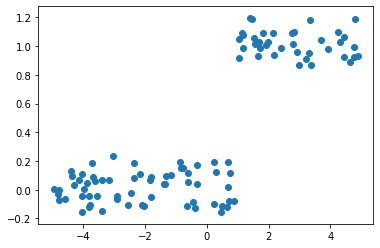

In [112]:
X, Y = make_some_data(100, 0)
plt.scatter(X,Y)
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2, random_state=0)
reg = TreeRegressor(max_depth=5)
reg.fit(Xtrain, Ytrain)
mse = mean_squared_error(Ytest, reg.predict(Xtest))
print(f'The MSE of the Tree regressor: {mse}')

'''
TO-DO:
- plot the split-point
''';

# Part 3: Predicting apartment prices using decision tree regression

In [136]:
reg = TreeRegressor(max_depth=5)
reg_score = min_avg_max(cross_validate(reg, Xtrain, Ytrain, cv=5, scoring="neg_mean_squared_error"))
print('The MSE of the Tree regressor on the training data:', reg_score)

The MSE of the Tree regressor on the training data: [0.02564028 0.12751146 0.25741517]


In [140]:
reg.fit(Xtrain, Ytrain)
mse = mean_squared_error(Ytest, reg.predict(Xtest))
print(f'The MSE of the Tree regressor on the test data: {mse}')

The MSE of the Tree regressor on the test data: 0.22892572628283192


# Part 4: Underfitting and overfitting

In [154]:
def fitting_curves(n):
    depths = []
    train_error = []
    test_error = []
    for i in range(1,n+1):
        depths.append(i)
        
        reg = TreeRegressor(i)
        reg_score = min_avg_max(cross_validate(reg, Xtrain, Ytrain, cv=5, scoring="neg_mean_squared_error"))[1]
        reg.fit(Xtrain, Ytrain)
        mse = mean_squared_error(Ytest, reg.predict(Xtest))
        
        train_error.append(reg_score)
        test_error.append(mse)
        
    plt.plot(depths, train_error, 'b', test_error, 'r')
    #plt.legend((train_error, test_error), ('train error', 'test error'))
    
    return depths, train_error, test_error

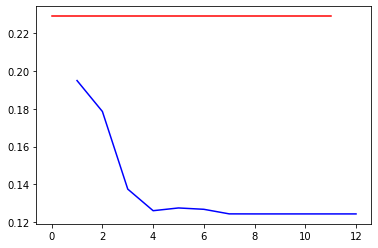

In [153]:
fitting_curves(12);

# Extra (code to remove)

In [46]:
reg = TreeRegressor2(max_depth=5)
reg_score = min_avg_max(cross_validate(reg, Xtrain, Ytrain, cv=5, scoring="neg_mean_squared_error"))
print('The MSE of the Tree regressor on the training data:', reg_score)

C:\Users\46703\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:530: FutureWarning: From version 0.22, errors during fit will result in a cross validation score of NaN by default. Use error_score='raise' if you want an exception raised or error_score=np.nan to adopt the behavior from version 0.22.
  FutureWarning)


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
reg.fit(Xtrain, Ytrain)
mse = mean_squared_error(Ytest, reg.predict(Xtest))
print(f'The MSE of the Tree regressor on the test data: {mse}')

In [ ]:
'''class TreeRegressor(DecisionTree, RegressorMixin):
    
    def __init__(self, max_depth=10, criterion='maj_sum'):
        super().__init__(max_depth)
        self.criterion = criterion
    
    def fit(self, X, Y):
        # For decision tree classifiers, there are some different ways to measure
        # the homogeneity of subsets.
        if self.criterion == 'maj_sum':
            self.criterion_function = majority_sum_scorer
        elif self.criterion == 'info_gain':
            self.criterion_function = info_gain_scorer
        elif self.criterion == 'gini':
            self.criterion_function = gini_scorer
        else:
            raise Exception(f'Unknown criterion: {self.criterion}')
        super().fit(X, Y)
        self.classes_ = sorted(set(Y))
    
    # Select a default value that is going to be used if we decide to make a leaf.
    # We will select the most common value.
    def get_default_value(self, Y):
        self.class_distribution = Counter(Y)
        return np.mean(self.class_distribution(1)[0][0])
    
    # Checks whether a set of output values is homogeneous. In the classification case, 
    # this means that all output values are identical.
    # We assume that we called get_default_value just before, so that we can access
    # the class_distribution attribute. If the class distribution contains just one item,
    # this means that the set is homogeneous.
    def is_homogeneous(self, Y):
        return np.var(self.class_distribution) > threshold
    
    #^THRESHOLD?
    
    #how to find best split??
    
    # Finds the best splitting point for a given feature. We'll keep frequency tables (Counters)
    # for the upper and lower parts, and then compute the impurity criterion using these tables.
    # In the end, we return a triple consisting of
    # - the best score we found, according to the criterion we're using
    # - the id of the feature
    # - the threshold for the best split
    def best_split(self, X, Y, feature):

        # Create a list of input-output pairs, where we have sorted
        # in ascending order by the input feature we're considering.
        XY = sorted(zip(X[:, feature], Y))

        n = len(XY)

        # The frequency tables corresponding to the parts *before and including*
        # and *after* the current element.
        low_distr = Counter()
        high_distr = Counter(Y)

        # Keep track of the best result we've seen so far.
        max_score = -np.inf
        max_i = None

        # Go through all the positions (excluding the last position).
        for i in range(0, n-1):

            # Input and output at the current position.
            x_i = XY[i][0]
            y_i = XY[i][1]

            # Update the frequency tables.
            low_distr[y_i] += 1
            high_distr[y_i] -= 1

            # If the input is equal to the input at the next position, we will
            # not consider a split here.
            x_next = XY[i+1][0]
            if x_i == x_next:
                continue

            # Compute the homogeneity criterion for a split at this position.
            score = self.criterion_function(i+1, low_distr, n-i-1, high_distr)

            # If this is the best split, remember it.
            if score > max_score:
                max_score = score
                max_i = i

        # If we didn't find any split (meaning that all inputs are identical), return
        # a dummy value.
        if max_i is None:
            return -np.inf, None, None

        # Otherwise, return the best split we found and its score.
        split_point = 0.5*(XY[max_i][0] + XY[max_i+1][0])
        return max_score, feature, split_point
''';